# Model Processing

## Imports & General Settings 

In [1]:
import unittest
import os
import sys
import time
import pathlib

import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToPILImage
import PIL
from tqdm.notebook import trange, tqdm
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, roc_curve, roc_auc_score
from matplotlib import pyplot
from scipy.signal import resample


# Our imports
from data import WaveletTransform, AFECGDataset, SecondDataset, WrapperDataset
import dsp
from model.blocks import ConvNet, BRNN, SoftmaxAttention
from model.baseline import Baseline
from model.tcnnet import TCNNet
from training import train, test, save_model, load_model
from evaluate import calc_roc_curve, evaluate_metrics


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
testCase = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## Dataset creation

In [3]:
seq_len = 4

In [4]:
dataset_name = 'afdb'
dataset = AFECGDataset(dataset_name, '../data/afdb/', wavelet=WaveletTransform(resample=20), seq_len=seq_len)

In [5]:
# dataset.load(num_records=1)
dataset.load('./temp/' + dataset_name + '_small')

Loaded from backup


In [6]:
total_data_size = len(dataset)
print("Total data size: ", total_data_size)
print("Samples with AF: ", dataset.labels.sum().item())
print('Data shape: ', dataset.samples.shape)

Total data size:  7009
Samples with AF:  408
Data shape:  torch.Size([7009, 4, 92, 375])


##  Wavelet Transform

Has AF:  Yes


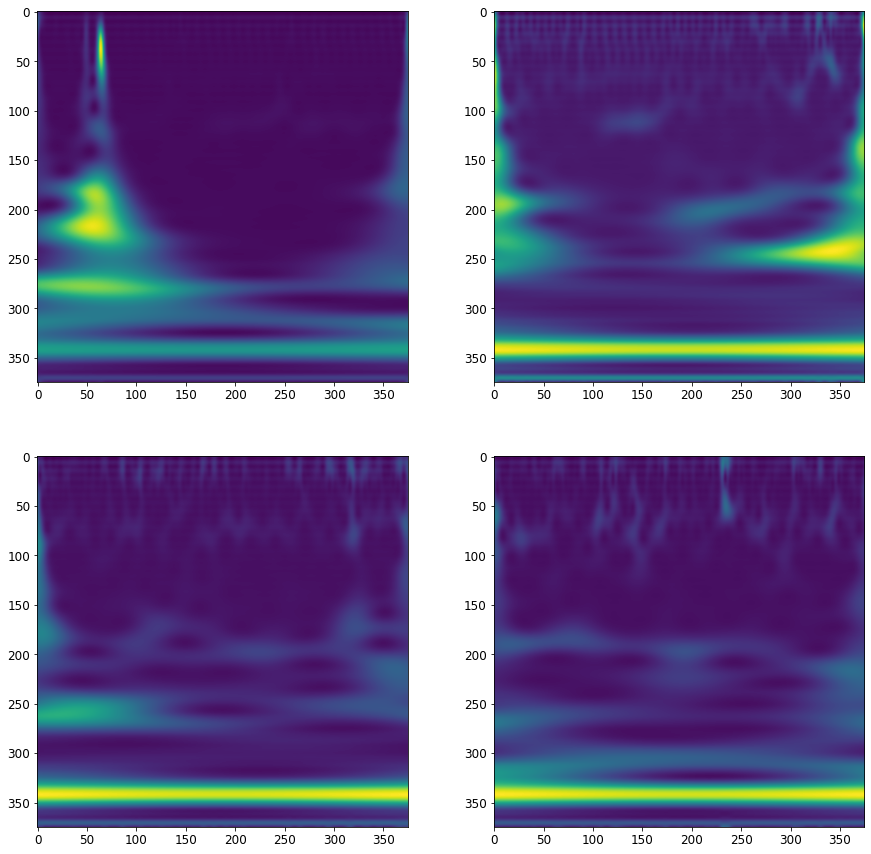

In [7]:
powers, label = dataset[3]
print('Has AF: ', 'Yes' if label == 1 else 'No')

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.reshape(-1)
for power, ax in zip(powers, axes):
    signal = resample(power, 375)
    ax.imshow(signal)

plt.show()

## Training

In [8]:
old_dataset = dataset

true_idx = [i for i, x in enumerate(dataset.labels == 1) if x == True]
false_idx = [i for i, x in enumerate(dataset.labels == 0) if x == True]
print("True idx total, False idx total: ", len(true_idx), len(false_idx))

idxes = true_idx + false_idx[0:int(len(true_idx) * 7/3)]
print(len(idxes))
dataset = torch.utils.data.Subset(dataset, list(set(idxes)))

True idx total, False idx total:  408 6601
1360


In [9]:
heldout = int(len(dataset) * 0.3)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - heldout, heldout])
train_indices = train_dataset.indices
test_indices = test_dataset.indices
# print('[Train] Positive cases = {}'.format((dataset.labels[train_indices] == 1).sum()))
# print('[Test] Positive cases = {}'.format((dataset.labels[test_indices] == 1).sum()))

### Baseline

In [62]:
model = Baseline(seq_len=seq_len)
model = model.to(device)

config = dict(
    num_workers=4,
    batch_size=32,
    learning_rate=0.0009,
    weight_decay=0.03,
    num_epochs=100,
    is_notebook=True,
    verbose=False
)

losses, accuracies = train(model, train_dataset, config, device)


Epoch [1/100], Accuracy: 63.24%



Epoch [2/100], Accuracy: 70.59%



Epoch [3/100], Accuracy: 69.22%



Epoch [4/100], Accuracy: 70.80%



Epoch [5/100], Accuracy: 69.43%



Epoch [6/100], Accuracy: 70.59%



Epoch [7/100], Accuracy: 72.16%



Epoch [8/100], Accuracy: 75.74%



Epoch [9/100], Accuracy: 79.62%



Epoch [10/100], Accuracy: 78.26%



Epoch [11/100], Accuracy: 84.24%



Epoch [12/100], Accuracy: 81.30%



Epoch [13/100], Accuracy: 78.05%



Epoch [14/100], Accuracy: 81.62%



Epoch [15/100], Accuracy: 83.61%



Epoch [16/100], Accuracy: 85.92%



Epoch [17/100], Accuracy: 86.34%



Epoch [18/100], Accuracy: 86.34%



Epoch [19/100], Accuracy: 87.18%



Epoch [20/100], Accuracy: 87.82%



Epoch [21/100], Accuracy: 86.87%



Epoch [22/100], Accuracy: 83.82%



Epoch [23/100], Accuracy: 82.46%



Epoch [24/100], Accuracy: 82.46%



Epoch [25/100], Accuracy: 87.61%



Epoch [26/100], Accuracy: 82.77%



Epoch [27/100], Accuracy: 84.14%



Epoch [28/100], Accuracy: 81.72%



Epoch [29/100], Accuracy: 82.98%



Epoch [30/100], Accuracy: 84.98%



Epoch [31/100], Accuracy: 85.71%



Epoch [32/100], Accuracy: 85.08%



Epoch [33/100], Accuracy: 85.29%



Epoch [34/100], Accuracy: 86.03%



Epoch [35/100], Accuracy: 86.13%



Epoch [36/100], Accuracy: 82.56%



Epoch [37/100], Accuracy: 84.03%



Epoch [38/100], Accuracy: 84.56%



Epoch [39/100], Accuracy: 86.76%



Epoch [40/100], Accuracy: 86.55%



Epoch [41/100], Accuracy: 85.29%



Epoch [42/100], Accuracy: 87.18%



Epoch [43/100], Accuracy: 87.50%



Epoch [44/100], Accuracy: 86.66%



Epoch [45/100], Accuracy: 88.66%



Epoch [46/100], Accuracy: 87.08%



Epoch [47/100], Accuracy: 88.55%



Epoch [48/100], Accuracy: 89.81%



Epoch [49/100], Accuracy: 82.56%



Epoch [50/100], Accuracy: 90.23%



Epoch [51/100], Accuracy: 88.45%



Epoch [52/100], Accuracy: 86.24%



Epoch [53/100], Accuracy: 89.08%



Epoch [54/100], Accuracy: 89.39%



Epoch [55/100], Accuracy: 87.82%



Epoch [56/100], Accuracy: 90.23%



Epoch [57/100], Accuracy: 88.45%



Epoch [58/100], Accuracy: 91.70%



Epoch [59/100], Accuracy: 84.87%



Epoch [60/100], Accuracy: 85.92%



Epoch [61/100], Accuracy: 91.28%



Epoch [62/100], Accuracy: 88.45%



Epoch [63/100], Accuracy: 89.92%



Epoch [64/100], Accuracy: 89.08%



Epoch [65/100], Accuracy: 91.39%



Epoch [66/100], Accuracy: 90.34%



Epoch [67/100], Accuracy: 88.55%



Epoch [68/100], Accuracy: 90.02%



Epoch [69/100], Accuracy: 89.92%



Epoch [70/100], Accuracy: 86.45%



Epoch [71/100], Accuracy: 84.66%



Epoch [72/100], Accuracy: 91.28%



Epoch [73/100], Accuracy: 92.02%



Epoch [74/100], Accuracy: 90.65%



Epoch [75/100], Accuracy: 89.60%



Epoch [76/100], Accuracy: 89.50%



Epoch [77/100], Accuracy: 88.97%



Epoch [78/100], Accuracy: 89.29%



Epoch [79/100], Accuracy: 85.50%



Epoch [80/100], Accuracy: 91.18%



Epoch [81/100], Accuracy: 89.08%



Epoch [82/100], Accuracy: 89.50%



Epoch [83/100], Accuracy: 88.97%



Epoch [84/100], Accuracy: 88.45%



Epoch [85/100], Accuracy: 88.13%



Epoch [86/100], Accuracy: 90.55%



Epoch [87/100], Accuracy: 86.45%



Epoch [88/100], Accuracy: 90.65%



Epoch [89/100], Accuracy: 91.07%



Epoch [90/100], Accuracy: 90.97%



Epoch [91/100], Accuracy: 92.23%



Epoch [92/100], Accuracy: 90.97%



Epoch [93/100], Accuracy: 92.12%



Epoch [94/100], Accuracy: 90.76%



Epoch [95/100], Accuracy: 91.07%



Epoch [96/100], Accuracy: 87.82%



Epoch [97/100], Accuracy: 89.50%



Epoch [98/100], Accuracy: 90.13%



Epoch [99/100], Accuracy: 92.44%



Epoch [100/100], Accuracy: 89.81%



In [63]:
checkpoint_dir = './checkpoints'
checkpoint_file = 'baseline_{}_{}.pt'.format(config['num_epochs'], config['batch_size'])
save_model(model, config, checkpoint_file, checkpoint_dir)

#### Training results


Testing model...



Accuracy: 86.87%


,precision,recall,f1-score,support
0,0.958549,0.846037,0.898785,656.000000
1,0.729223,0.918919,0.813154,296.000000
accuracy,0.868697,0.868697,0.868697,0.868697
macro avg,0.843886,0.882478,0.855970,952.000000
weighted avg,0.887246,0.868697,0.872161,952.000000


Specificity: 0.8460365853658537
AUC: 0.8824777521423863
ROC AUC=0.882
PR AUC: 0.6953064538618868


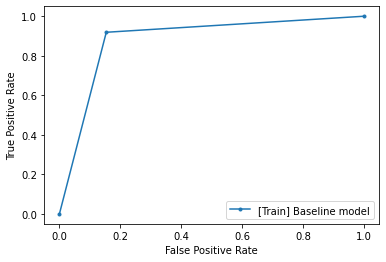

In [65]:
y_pred_train, train_acc = test(model, train_dataset, config, device)
y_true_train = [y for x, y in train_dataset]
results_train, specificity_train, auc_score_train = evaluate_metrics(y_true_train, y_pred_train)
display(results_train)
print("Specificity:", specificity_train)
print("AUC:", auc_score_train)
calc_roc_curve(y_true_train, y_pred_train, label='[Train] Baseline model')

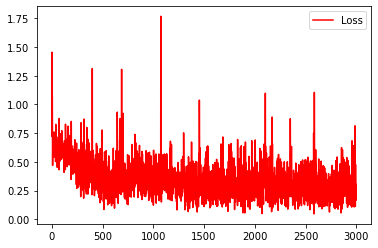

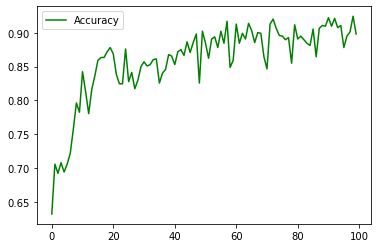

In [66]:
train_time = np.arange(len(losses))
plt.plot(train_time, losses, '-r', label='Loss')
plt.legend(loc='best')
plt.show()


plt.plot(np.arange(config['num_epochs']), accuracies, 'g', label='Accuracy')
plt.legend(loc='best')
plt.show()

#### Testing results

In [67]:
config['verbose'] = False
y_pred, test_acc = test(model, test_dataset, config, device)

Testing model...



Accuracy: 81.13%


,precision,recall,f1-score,support
0,0.932806,0.797297,0.859745,296.000000
1,0.612903,0.848214,0.711610,112.000000
accuracy,0.811275,0.811275,0.811275,0.811275
macro avg,0.772855,0.822756,0.785678,408.000000
weighted avg,0.844990,0.811275,0.819081,408.000000


Specificity: 0.7972972972972973
AUC: 0.8227557915057915
ROC AUC=0.823
PR AUC: 0.5615399385560675


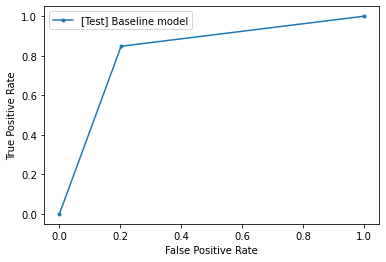

In [68]:
y_true = [y for x, y in test_dataset]
results, specificity, auc_score = evaluate_metrics(y_true, y_pred)
display(results)
print("Specificity:", specificity)
print("AUC:", auc_score)
calc_roc_curve(y_true, y_pred, label='[Test] Baseline model')

### TCNNet

In [33]:
model = TCNNet(seq_len=seq_len)
model = model.to(device)

config = dict(
    num_workers=4,
    batch_size=16,
    learning_rate=0.0005,
    weight_decay=0.01,
    num_epochs=100,
    is_notebook=True,
    verbose=False
)

losses, accuracies = train(model, train_dataset, config, device)


Epoch [1/28], Accuracy: 72.16%



Epoch [2/28], Accuracy: 80.15%



Epoch [3/28], Accuracy: 82.25%



Epoch [4/28], Accuracy: 83.40%



Epoch [5/28], Accuracy: 85.82%



Epoch [6/28], Accuracy: 88.13%



Epoch [7/28], Accuracy: 88.13%



Epoch [8/28], Accuracy: 91.60%



Epoch [9/28], Accuracy: 89.71%



Epoch [10/28], Accuracy: 90.76%



Epoch [11/28], Accuracy: 90.02%



Epoch [12/28], Accuracy: 90.86%



Epoch [13/28], Accuracy: 91.81%



Epoch [14/28], Accuracy: 91.49%



Epoch [15/28], Accuracy: 91.28%



Epoch [16/28], Accuracy: 92.23%



Epoch [17/28], Accuracy: 92.44%



Epoch [18/28], Accuracy: 92.54%



Epoch [19/28], Accuracy: 92.96%



Epoch [20/28], Accuracy: 92.86%



Epoch [21/28], Accuracy: 93.07%



Epoch [22/28], Accuracy: 94.01%



Epoch [23/28], Accuracy: 94.96%



Epoch [24/28], Accuracy: 94.75%



Epoch [25/28], Accuracy: 94.54%



Epoch [26/28], Accuracy: 94.43%



Epoch [27/28], Accuracy: 95.06%



Epoch [28/28], Accuracy: 94.64%



#### Training results

In [34]:
y_pred_train, train_acc = test(model, train_dataset, config, device)

Testing model...



Accuracy: 93.80%


,precision,recall,f1-score,support
0,0.972393,0.939259,0.955539,675.000000
1,0.863333,0.935018,0.897747,277.000000
accuracy,0.938025,0.938025,0.938025,0.938025
macro avg,0.917863,0.937139,0.926643,952.000000
weighted avg,0.940660,0.938025,0.938723,952.000000


Specificity: 0.9392592592592592
AUC: 0.9371386549003877
ROC AUC=0.937
PR AUC: 0.8261398133260525


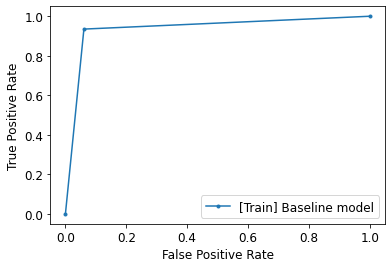

In [35]:
y_true_train = [y for x, y in train_dataset]
results_train, specificity_train, auc_score_train = evaluate_metrics(y_true_train, y_pred_train)
display(results_train)
print("Specificity:", specificity_train)
print("AUC:", auc_score_train)
calc_roc_curve(y_true_train, y_pred_train, label='[Train] Baseline model')

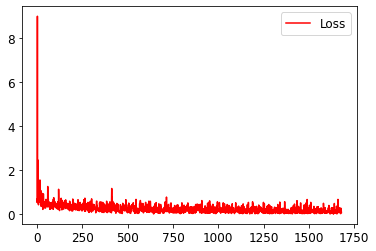

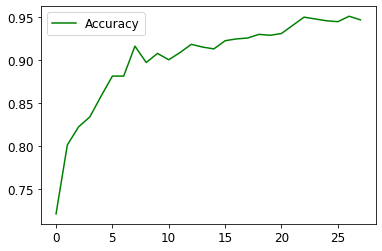

In [36]:
train_time = np.arange(len(losses))
plt.plot(train_time, losses, '-r', label='Loss')
plt.legend(loc='best')
plt.show()


plt.plot(np.arange(config['num_epochs']), accuracies, 'g', label='Accuracy')
plt.legend(loc='best')
plt.show()

#### Testing results

In [37]:
config['verbose'] = False
y_pred, test_acc = test(model, test_dataset, config, device)

Testing model...



Accuracy: 87.99%


,precision,recall,f1-score,support
0,0.919118,0.902527,0.910747,277.000000
1,0.801471,0.832061,0.816479,131.000000
accuracy,0.879902,0.879902,0.879902,0.879902
macro avg,0.860294,0.867294,0.863613,408.000000
weighted avg,0.881344,0.879902,0.880480,408.000000


Specificity: 0.9025270758122743
AUC: 0.8672940722572822
ROC AUC=0.867
PR AUC: 0.720794042807963


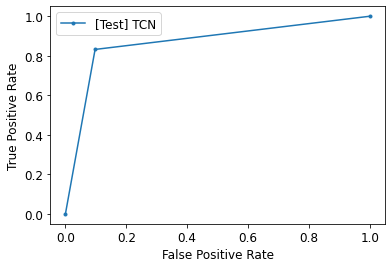

In [39]:
y_true = [y for x, y in test_dataset]
results, specificity, auc_score = evaluate_metrics(y_true, y_pred)
display(results)
print("Specificity:", specificity)
print("AUC:", auc_score)
calc_roc_curve(y_true, y_pred, label='[Test] TCN')